In [1]:
%load_ext lab_black
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from admix.data import quantile_normalize
import seaborn as sns
import admix
import admix_genet_cor
import os
from scipy.stats import pearsonr, linregress
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.patches as mpatches

np.random.seed(1234)

plt.rcParams["font.family"] = ["Liberation Sans"]

In [2]:
# SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp-tables.xlsx?dl=1"
SUPP_TABLE_URL = "supp-tables.xlsx"
df_trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="ukb-trait-info")
ukb_trait_list = df_trait_info[df_trait_info["in-analysis"] == "T"].id.values
ukb_name_dict = (
    df_trait_info[["id", "display-name"]].set_index("id")["display-name"].to_dict()
)


df_trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name="page-trait-info")
page_trait_list = df_trait_info.trait.values
page_name_dict = (
    df_trait_info[["trait", "display-name"]]
    .set_index("trait")["display-name"]
    .to_dict()
)

aou_name_dict = {
    "bmi": "BMI",
    "diastolic_blood_pressure": "Diastolic blood pressure",
    "systolic_blood_pressure": "Systolic blood pressure",
    "HDL": "HDL",
    "LDL_adjusted": "LDL",
    "heart_rate": "Heart rate",
    "height": "Height",
    "TC_adjusted": "Total cholesterol",
    "TG_adjusted": "Triglycerides",
    "waist_hip_ratio": "WHR",
}

In [3]:
dict_df_het = {}
for study in ["ukb", "page", "aou"]:

    name_dict = {"page": page_name_dict, "ukb": ukb_name_dict, "aou": aou_name_dict}[
        study
    ]
    df = pd.read_csv(f"out/summary/{study}_het_info.tsv", sep="\t")
    df["CHROM"] = df.snp.apply(lambda x: int(x.split(":")[0][3:]))
    df["POS"] = df.snp.apply(lambda x: int(x.split(":")[1]))
    df["STUDY"] = study
    df["TRAIT"] = df["TRAIT"].apply(lambda t: name_dict[t])
    dict_df_het[study] = df

In [4]:
df_assoc = pd.concat(
    [dict_df_het["ukb"], dict_df_het["page"], dict_df_het["aou"]], axis=0
).reset_index(drop=True)

df_assoc.loc[:, "expected_HET_P"] = stats.norm.sf(quantile_normalize(-df_assoc.HET_P))
df_assoc.loc[:, "bonferroni_significant"] = df_assoc["HET_P"] < 0.05 / len(df_assoc)

df_assoc = df_assoc[df_assoc["ATT_P"] < 5e-8]

df_assoc = df_assoc.rename(
    columns={
        "G1_BETA": "EUR_BETA",
        "G1_SE": "EUR_SE",
        "G2_BETA": "AFR_BETA",
        "G2_SE": "AFR_SE",
    }
)

In [5]:
def report_assoc(df_assoc, direction="AFR~EUR"):

    deming_list = []
    ols_list = []
    pearsonr_list = []

    def deming_slope(df, direction):
        assert direction in ["AFR~EUR", "EUR~AFR"]
        if direction == "AFR~EUR":
            return admix.data.deming_regression(
                x=df["EUR_BETA"],
                y=df["AFR_BETA"],
                sx=df["EUR_SE"],
                sy=df["AFR_SE"],
            )[0]
        else:
            return admix.data.deming_regression(
                x=df["AFR_BETA"],
                y=df["EUR_BETA"],
                sx=df["AFR_SE"],
                sy=df["EUR_SE"],
            )[0]

    def ols_slope(df, direction):
        assert direction in ["AFR~EUR", "EUR~AFR"]
        if direction == "AFR~EUR":
            return linregress(x=df["EUR_BETA"], y=df["AFR_BETA"])[0]
        else:
            return linregress(x=df["AFR_BETA"], y=df["EUR_BETA"])[0]

    for _ in range(1000):
        df_tmp = df_assoc.sample(len(df_assoc), replace=True)
        deming_list.append(deming_slope(df_tmp, direction))
        ols_list.append(ols_slope(df_tmp, direction))
        pearsonr_list.append(pearsonr(df_tmp.EUR_BETA, df_tmp.AFR_BETA)[0])

    deming = deming_slope(df_assoc, direction)
    ols = ols_slope(df_assoc, direction)
    lgc, lgc_ci = admix.data.lambda_gc(df_assoc.HET_P, bootstrap_ci=True)

    print(f"{len(df_assoc)} SNPs")
    print(
        f"Pearson's r = {stats.pearsonr(df_assoc.EUR_BETA, df_assoc.AFR_BETA)[0]:.2g}, SE={np.std(pearsonr_list):.2f}"
    )
    print(
        f"Deming regression slope: {deming:.2f}. Bootstrap mean (se): {np.mean(deming_list):.2f} ({np.std(deming_list):.2f})"
    )
    print(
        f"OLS regression slope: {ols:.2f}. Bootstrap mean (se): {np.mean(ols_list):.2f} ({np.std(ols_list):.2f})"
    )
    print(f"lambda gc = {lgc:.2f}, ci=[{lgc_ci[0]:.2f}, {lgc_ci[1]:.2f}]")

In [6]:
mch_chr16_snps = df_assoc.TRAIT.isin(["MCH"]) & (df_assoc.CHROM == 16)

In [7]:
print(np.sum(df_assoc.bonferroni_significant))

41


In [8]:
df_assoc[df_assoc.bonferroni_significant].groupby(["TRAIT", "STUDY"]).size()

TRAIT               STUDY
C-reactive protein  page      1
Height              aou      22
LDL                 aou       1
MCH                 ukb      14
RBC count           ukb       1
Total cholesterol   aou       2
dtype: int64

In [9]:
df_assoc[df_assoc.bonferroni_significant].groupby(["TRAIT", "STUDY"]).apply(
    lambda df: [len(df), f"{np.mean(-np.log10(df.HET_P)):.2g}"]
)

TRAIT               STUDY
C-reactive protein  page      [1, 4.1]
Height              aou      [22, 6.8]
LDL                 aou       [1, 6.8]
MCH                 ukb       [14, 13]
RBC count           ukb       [1, 5.5]
Total cholesterol   aou       [2, 5.8]
dtype: object

In [10]:
for direction in ["AFR~EUR", "EUR~AFR"]:
    print(f"## {direction}")
    print("# all SNPs")
    report_assoc(df_assoc, direction)
    print("")
    print("# SNPs removing MCH")
    report_assoc(df_assoc[~mch_chr16_snps], direction)
    print("")

## AFR~EUR
# all SNPs
217 SNPs
Pearson's r = 0.73, SE=0.04
Deming regression slope: 1.22. Bootstrap mean (se): 1.22 (0.09)
OLS regression slope: 0.83. Bootstrap mean (se): 0.84 (0.06)
lambda gc = 4.92, ci=[3.39, 7.34]

# SNPs removing MCH
193 SNPs
Pearson's r = 0.85, SE=0.03
Deming regression slope: 1.08. Bootstrap mean (se): 1.08 (0.05)
OLS regression slope: 0.92. Bootstrap mean (se): 0.92 (0.05)
lambda gc = 3.94, ci=[3.22, 5.90]

## EUR~AFR
# all SNPs
217 SNPs
Pearson's r = 0.73, SE=0.04
Deming regression slope: 0.82. Bootstrap mean (se): 0.82 (0.06)
OLS regression slope: 0.64. Bootstrap mean (se): 0.64 (0.06)
lambda gc = 4.92, ci=[3.39, 7.45]

# SNPs removing MCH
193 SNPs
Pearson's r = 0.85, SE=0.03
Deming regression slope: 0.93. Bootstrap mean (se): 0.93 (0.04)
OLS regression slope: 0.79. Bootstrap mean (se): 0.80 (0.06)
lambda gc = 3.94, ci=[3.23, 5.91]



In [11]:
df_plot = df_assoc.copy()

In [13]:
cmap = plt.get_cmap("Set1")
dict_color = dict()
signif_trait_list = (
    df_plot.loc[df_plot.bonferroni_significant]
    .groupby("TRAIT")
    .apply(lambda df: np.log10(df["HET_P"]).mean())
    .sort_values()
    .index.values
)
for i, trait in enumerate(signif_trait_list):
    dict_color[trait] = cmap(i)
dict_trait_name = {t: t for t in signif_trait_list}
dict_trait_name["C-reactive protein"] = "CRP"
dict_trait_name["Total cholesterol"] = "TC"

In [14]:
df_plot["color"] = df_plot.apply(
    lambda x: dict_color[x.TRAIT] if x.bonferroni_significant else "black", axis=1
)

In [27]:
def plot_slope_range(slope, range1, range2, color, ax, lw=1, ls="--"):
    xlim = np.array(ax.get_xlim())
    line = ax.axline((0, 0), slope=slope, color=color, lw=lw, ls=ls)
    shade = ax.fill_between(
        xlim, xlim * range1, xlim * range2, color=color, alpha=0.1, edgecolor=None
    )
    return line, shade

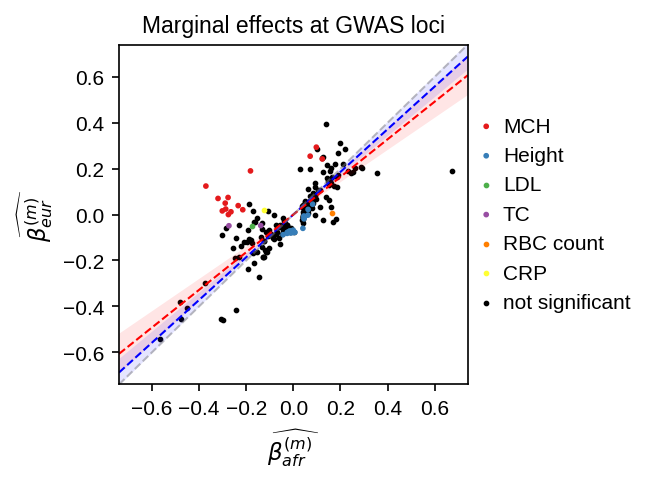

In [56]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)

# bonferroni significant
df_tmp = df_plot[df_plot.bonferroni_significant]
assert set(df_tmp.TRAIT) == set(dict_trait_name.keys())
for trait in dict_trait_name:
    df = df_tmp[df_tmp.TRAIT == trait]
    ax.scatter(
        df["AFR_BETA"],
        df["EUR_BETA"],
        s=3,
        color=df["color"],
        label=dict_trait_name[trait],
    )

# background
df_tmp = df_plot[~df_plot.bonferroni_significant]
ax.scatter(
    df_tmp["AFR_BETA"],
    df_tmp["EUR_BETA"],
    s=3,
    color="black",
    label="not significant",
    zorder=-1,
)

ax.set_xlabel("$\\widehat{\\beta_{afr}^{(m)}}$", fontsize=11)
ax.set_ylabel("$\\widehat{\\beta_{eur}^{(m)}}$", fontsize=11)
lim = df_plot[["AFR_BETA", "EUR_BETA"]].abs().max().max() * 1.1
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks(np.linspace(-0.6, 0.6, 7))
ax.set_yticks(np.linspace(-0.6, 0.6, 7))

# slope 1
slope_estimate = 0.93
slope_se = 0.04

slope_line, slope_shade = plot_slope_range(
    slope_estimate,
    slope_estimate - slope_se * 1.96,
    slope_estimate + slope_se * 1.96,
    color="blue",
    ax=ax,
)


# slope 2
slope_estimate = 0.82
slope_se = 0.06

slope_line, slope_shade = plot_slope_range(
    slope_estimate,
    slope_estimate - slope_se * 1.96,
    slope_estimate + slope_se * 1.96,
    color="red",
    ax=ax,
)

# dots legend
ax.axline((0, 0), slope=1, color="gray", ls="--", lw=1.0, alpha=0.5)
ax.legend(
    bbox_to_anchor=(1.23, 0.5),
    loc="center",
    frameon=False,
    handletextpad=-0.2,
)


ax.set_title("Marginal effects at GWAS loci", fontsize=11)

plt.savefig("results/marginal-effects.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)

# bonferroni significant
df_tmp = df_plot[df_plot.bonferroni_significant]
assert set(df_tmp.TRAIT) == set(dict_trait_name.keys())
for trait in dict_trait_name:
    df = df_tmp[df_tmp.TRAIT == trait]
    ax.scatter(
        df["AFR_BETA"],
        df["EUR_BETA"],
        s=-np.log10(df["HET_P"]) * 2,
        color=df["color"],
        label=dict_trait_name[trait],
    )

# background
df_tmp = df_plot[~df_plot.bonferroni_significant]
ax.scatter(
    df_tmp["AFR_BETA"],
    df_tmp["EUR_BETA"],
    s=-np.log10(df_tmp["HET_P"]) + 1,
    color="black",
    label="not significant",
    zorder=-1,
)

ax.set_xlabel("$\\widehat{\\beta_{afr}^{(m)}}$", fontsize=11)
ax.set_ylabel("$\\widehat{\\beta_{eur}^{(m)}}$", fontsize=11)
lim = df_plot[["AFR_BETA", "EUR_BETA"]].abs().max().max() * 1.1
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_xticks(np.linspace(-0.6, 0.6, 7))
ax.set_yticks(np.linspace(-0.6, 0.6, 7))

# slope 1
slope_estimate = 0.93
slope_se = 0.04

slope_line, slope_shade = plot_slope_range(
    slope_estimate,
    slope_estimate - slope_se * 1.96,
    slope_estimate + slope_se * 1.96,
    color="blue",
    ax=ax,
)

# slope 2
slope_estimate = 0.82
slope_se = 0.06

slope_line, slope_shade = plot_slope_range(
    slope_estimate,
    slope_estimate - slope_se * 1.96,
    slope_estimate + slope_se * 1.96,
    color="red",
    ax=ax,
)

# slope legend
# patch = mpatches.Patch(facecolor="gray", alpha=0.5, linewidth=0)
# slope_legend = ax.legend(
#     [(patch, slope_line)],
#     [f"Deming slope excl. MCH:\n{slope_estimate} (s.e. {slope_se})"],
#     handler_map={slope_line: HandlerLine2D(marker_pad=0)},
#     frameon=False,
#     fontsize=7,
#     handlelength=2.45,
# )
# ax.add_artist(slope_legend)

# dots legend
# ax.axline((0, 0), slope=1, color="black", ls="--", lw=1.2)
ax.legend(
    bbox_to_anchor=(1.23, 0.5),
    loc="center",
    frameon=False,
    handletextpad=-0.2,
)


ax.set_title("Marginal effects at GWAS loci", fontsize=11)

plt.savefig("results/marginal-effects.pdf", bbox_inches="tight")